# Qwen_2.5 Fine-tuning for text classification using LORA


### Requirements:
* A GPU with enough memory We are Using Google Colab T4 model!

### Installs
* They suggest using latest version of transformers
* Must restart after install because the accelerate package used in the hugging face trainer requires it.

In [ ]:
%pip install triton==2.3.1

  Using cached triton-2.3.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.4 kB)
Using cached triton-2.3.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (168.1 MB)


In [ ]:
# Install Hugging Face libraries
%pip install --upgrade "transformers==4.41.2" "numpy==1.26.4" "pandas==2.1.1" "matplotlib==3.8.1" "langchain==1.2.9" "langchain-community==0.4.1" "datasets==2.19.0" "accelerate==0.30.1" "evaluate==0.4.1" "huggingface_hub==0.23.2" "trl==0.8.6" "peft==0.10.0" "torch==2.2.2" tensorboard

### Big Picture Overview of Parameter Efficient Fine Tuning Methods like LoRA and QLoRA Fine Tuning for Sequence Classification

**The Essence of Fine-tuning**
- LLMs are pre-trained on vast amounts of data for broad language understanding.
- Fine-tuning is crucial for specializing in specific domains or tasks, involving adjustments with smaller, relevant datasets.

**Model Fine-tuning with PEFT: Exploring LoRA and QLoRA**
- Traditional fine-tuning is resource-intensive; PEFT (Parameter Efficient Fine-tuning) makes the process faster and less demanding.
- Focus on two PEFT methods: LoRA and QLoRA.

**The Power of PEFT**
- PEFT modifies only a subset of the LLM's parameters, enhancing speed and reducing memory demands, making it suitable for less powerful devices.

**LoRA: Efficiency through Adapters**
- **Low-Rank Adaptation (LoRA):** Injects small trainable adapters into the pre-trained model.
- **Equation:** For a weight matrix $W$, LoRA approximates $W = W_0 + BA$, where $W_0$ is the original weight matrix, and $BA$ represents the low-rank modification through trainable matrices $B$ and $A$.
- Adapters learn task nuances while keeping the majority of the LLM unchanged, minimizing overhead.

**QLoRA: Compression and Speed**
- **Quantized LoRA (QLoRA):** Extends LoRA by quantizing the model’s weights, further reducing size and enhancing speed.
- **Innovations in QLoRA:**
  1. **4-bit Quantization:** Uses a 4-bit data type, NormalFloat (NF4), for optimal weight quantization, drastically reducing memory usage.
  2. **Low-Rank Adapters:** Fine-tuned with 16-bit precision to effectively capture task-specific nuances.
  3. **Double Quantization:** Reduces quantization constants from 32-bit to 8-bit, saving additional memory without accuracy loss.
  4. **Paged Optimizers:** Manages memory efficiently during training, optimizing for large tasks.

**Why PEFT Matters**
- **Rapid Learning:** Speeds up model adaptation.
- **Smaller Footprint:** Eases deployment with reduced model size.
- **Edge-Friendly:** Fits better on devices with limited resources, enhancing accessibility.

**Conclusion**
- PEFT methods like LoRA and QLoRA revolutionize LLM fine-tuning by focusing on efficiency, facilitating faster adaptability, smaller models, and broader device compatibility but in our task we are going to use LORA.




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Fine-tuning for Classification:

####  Sequence Classification Head
- **Approach**: Add a sequence classification head (linear layer) on top of the Qwen Model transformer.
    - **Token Positioning**:
        - **With pad_token_id**: The model identifies and ignores padding tokens, using the last non-padding token for classification.
        - **Without pad_token_id**: It defaults to the last token in each sequence.
        - **inputs_embeds**: If embeddings are directly passed (without input_ids), the model cannot identify padding tokens and takes the last embedding in each sequence as the input for classification.
- **Input**: Specific sentences (e.g., "The dragon burned the village.").
- **Output**: Direct sentiment classification (e.g., "fantasy").
- **Training Objective**: Minimize cross-entropy loss between the predicted and the actual genre labels.

https://huggingface.co/Qwen/Qwen2.5-1.5B-Instruct

### Peft Configs
* Lora config for lora

### Going to use Hugginface Transformers trainer class: Main componenents
* Hugging face dataset (for train + eval)
* Data collater
* Compute Metrics
* Class weights since we use custom trainer and also custom weighted loss..
* trainingArgs: like # epochs, learning rate, weight decay etc..



### Login to huggingface hub to put your qwen token so we can access QWEN2.5 1.5B Param Pre-trained Model

In [ ]:
from google.colab import userdata
import wandb

wandb.login(key=userdata.get('wandb'))
hf_token = userdata.get('Hf_token')
!huggingface-cli login --token {hf_token}

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: [wandb.login()] Using explicit session credentials for https://api.wandb.ai.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yehiamagdy9 (yehiamagdy9-alexandria-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


#### Imports

In [ ]:
import os
import random
import functools
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import evaluate

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score

from datasets import Dataset, DatasetDict
from peft import LoraConfig, get_peft_model, TaskType

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import load_dataset
import pandas as pd
from langchain_community.document_loaders.dataframe import DataFrameLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [ ]:
try:
    import triton
    print(f"Triton installed: {triton.__version__}")
    from triton.ops.matmul_perf_model import early_config_prune
    print("Successfully imported triton.ops.matmul_perf_model")
except ImportError as e:
    print(f"Error importing triton or its submodule: {e}")

Triton installed: 2.3.1
Successfully imported triton.ops.matmul_perf_model


### Loading dataset from huggingface


In [ ]:
class StoryDatasetLoader:
    def __init__(self, dataset_name="FareedKhan/1k_stories_100_genre", columns=None):
        if columns is None:
            columns = ["id", "title", "story", "genre"]
        self.dataset_name = dataset_name
        self.columns = columns
        self.df = pd.DataFrame()
        self.documents = []
        self.chunked_documents = []

    def load_dataset(self, split="train"):
        """Load dataset from Hugging Face and convert to pandas DataFrame."""
        ds = load_dataset(self.dataset_name)
        self.df = ds[split].to_pandas()[self.columns]
        return self.df


In [ ]:
# Usage
loader = StoryDatasetLoader()
df = loader.load_dataset()
df

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

,id,title,story,genre
0,457580,The Chronicles of the Cosmic Rift,"In the year 2250, Earth had made significant s...",Science Fiction
1,297904,Eldoria's Enchanted Whispers,"In a land far away, where the sun shone bright...",Fantasy
2,620436,Echoes of Whispered Shadows,"Once upon a time, in a small, tranquil town ca...",Mystery
3,634687,Emerald Amulet Chronicles Revealed,"Once upon a time in the 16th century, a small ...",Historical Adventure
4,513427,The Shadows of St. Augustine,In the sun-drenched coastal city of St. August...,Thriller
...,...,...,...,...
995,489018,The Asteroids Secret,"In the distant year of 3025, the spacecraft Se...",Space Exploration
996,689389,The Gears of Destiny,"In the steam-powered city of Icarus, the clock...",Steampunk Fantasy
997,157117,The Great Heist,"Jack, a small-time crook, hatched a plan to st...",Noir Comedy
998,170613,The Unseen World,"In a small village, a curious phenomenon occur...",Social Commentary


### DataPreprocessing Techniques

##### Removing urls, special characters, whitespacese and lowercasing the stories

In [ ]:
import re

# clean_text function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)  # collapse multiple spaces
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # remove URLs
    text = text.strip()
    return text

df['story_processed'] = df['story'].apply(clean_text)


In [ ]:
df

,id,title,story,genre,story_processed
0,457580,The Chronicles of the Cosmic Rift,"In the year 2250, Earth had made significant s...",Science Fiction,"in the year 2250, earth had made significant s..."
1,297904,Eldoria's Enchanted Whispers,"In a land far away, where the sun shone bright...",Fantasy,"in a land far away, where the sun shone bright..."
2,620436,Echoes of Whispered Shadows,"Once upon a time, in a small, tranquil town ca...",Mystery,"once upon a time, in a small, tranquil town ca..."
3,634687,Emerald Amulet Chronicles Revealed,"Once upon a time in the 16th century, a small ...",Historical Adventure,"once upon a time in the 16th century, a small ..."
4,513427,The Shadows of St. Augustine,In the sun-drenched coastal city of St. August...,Thriller,in the sun-drenched coastal city of st. august...
...,...,...,...,...,...
995,489018,The Asteroids Secret,"In the distant year of 3025, the spacecraft Se...",Space Exploration,"in the distant year of 3025, the spacecraft se..."
996,689389,The Gears of Destiny,"In the steam-powered city of Icarus, the clock...",Steampunk Fantasy,"in the steam-powered city of icarus, the clock..."
997,157117,The Great Heist,"Jack, a small-time crook, hatched a plan to st...",Noir Comedy,"jack, a small-time crook, hatched a plan to st..."
998,170613,The Unseen World,"In a small village, a curious phenomenon occur...",Social Commentary,"in a small village, a curious phenomenon occur..."


Number of unique genres: 99

Number of stories per genre:
Historical Adventure: 20
Science Fiction: 10
Alternate Dimension: 10
Romantic Fantasy: 10
Technological Thriller: 10
Spy Fiction: 10
Workplace Drama: 10
Detective Fiction: 10
Existential Drama: 10
Medical Mystery: 10
Coming-of-Middle-Age: 10
Domestic Fiction: 10
Psychological Horror: 10
Nautical Fiction: 10
Generation Gap: 10
Military Fiction: 10
Religious Fiction: 10
Futuristic: 10
Anthology: 10
Philosophical Fiction: 10
Survival: 10
Soft Science Fiction: 10
Hard Science Fiction: 10
Space Western: 10
Time-Loop: 10
Political Satire: 10
Mystery Comedy: 10
Supernatural Drama: 10
Social Commentary: 10
Noir Comedy: 10
Steampunk Fantasy: 10
Space Exploration: 10
War Comedy: 10
Magical Girl: 10
Suburban Drama: 10
Virtual Reality: 10
Apocalyptic Comedy: 10
Space Thriller: 10
Regency Romance: 10
Mystery Thriller: 10
Artificial Intelligence: 10
Multiverse: 10
Quantum Fiction: 10
Animal Fantasy: 10
Supernatural Comedy: 10
Philosophical Co

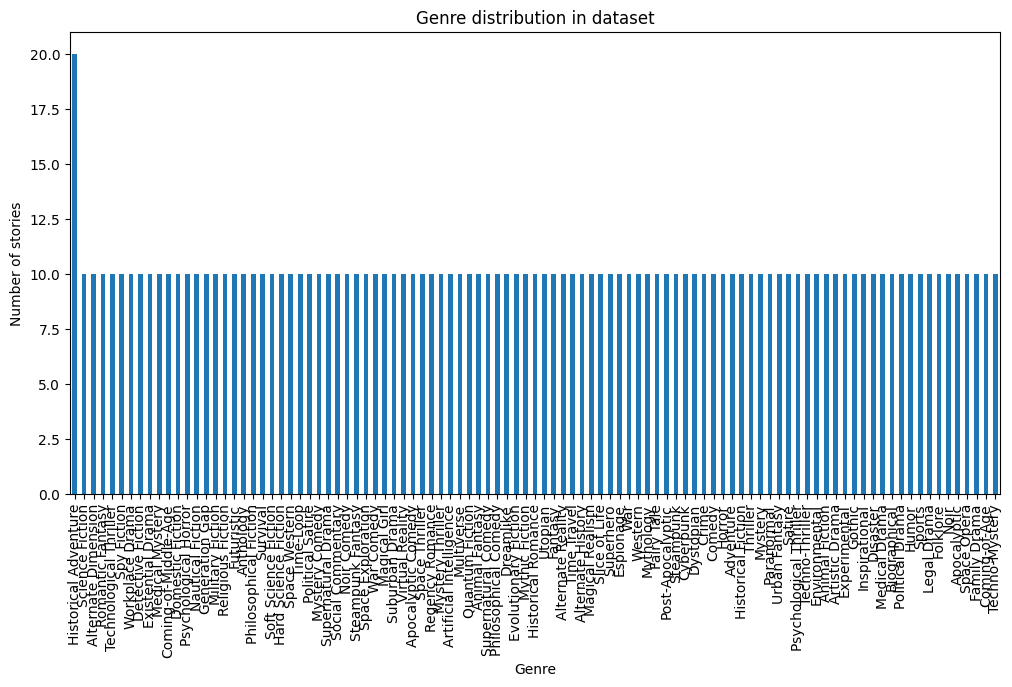

In [ ]:
# List unique genres
unique_genres = df['genre'].sort_values().unique()
num_classes = len(unique_genres)
print(f"Number of unique genres: {num_classes}\n")

# Print each genre and the number of stories in it
print("Number of stories per genre:")
genre_counts = df['genre'].value_counts()
for genre, count in genre_counts.items():
    print(f"{genre}: {count}")

#show missing or empty genres
missing_genres = df['genre'].isna().sum()
if missing_genres > 0:
    print(f"\nNumber of stories with missing genre: {missing_genres}")

# visualize the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
genre_counts.plot(kind='bar')
plt.title("Genre distribution in dataset")
plt.xlabel("Genre")
plt.ylabel("Number of stories")
plt.show()


* Add also a numeric 0,1,2 version of label since we will need it later for fine tuning. We can save it in 'target'

In [ ]:
unique_genres = sorted(df['genre'].unique())  # sort for reproducibility
genre2id = {genre: idx for idx, genre in enumerate(unique_genres)}

# Map genre strings to integer IDs
df['labels'] = df['genre'].map(genre2id)

# Verify
print(df[['genre', 'labels']].head())
print(f"Number of unique integer labels: {df['labels'].nunique()}")


                  genre  labels
0       Science Fiction      69
1               Fantasy      29
2               Mystery      48
3  Historical Adventure      35
4              Thriller      89
Number of unique integer labels: 99


In [ ]:
id2genre = {idx: genre for genre, idx in genre2id.items()}
genre1 = id2genre[89]
genre1

'Thriller'

In [ ]:
df = df[['story_processed', 'labels']]

### Split into train/val/test for later comparison.
* For simplicity.
  -  80% train
  -  10% val
  -  10% test



In [ ]:
from sklearn.model_selection import train_test_split

# Split into train + temp (val+test)
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['labels'],
    random_state=42
)

# Split temp into val + test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['labels'],
    random_state=42
)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


Train: 800, Val: 100, Test: 100


#### Chunking the data using

### Trying chunking the stories as a method for data augmentation and also to fit the model input size. We will use a chunk size of 2000 characters 

In [ ]:
def chunk_df(df_split, shuffle=False):
    loader = DataFrameLoader(df_split, page_content_column="story_processed")
    documents = loader.load()
    splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=0)
    chunked_docs = splitter.split_documents(documents)

    chunks_list = [{"text": doc.page_content, "labels": doc.metadata["labels"]} for doc in chunked_docs]
    df_chunks = pd.DataFrame(chunks_list)

    if shuffle:
        df_chunks = df_chunks.sample(frac=1, random_state=42).reset_index(drop=True)

    return df_chunks

# Shuffle only training chunks
train_chunks = chunk_df(train_df, shuffle=True)
val_chunks   = chunk_df(val_df, shuffle=False)
test_chunks  = chunk_df(test_df, shuffle=False)
print(f"Train chunks: {len(train_chunks)}, Val chunks: {len(val_chunks)}, Test chunks: {len(test_chunks)}")

Train chunks: 2720, Val chunks: 342, Test chunks: 353


### Convert from Pandas DataFrame to Hugging Face Dataset
* Also let's shuffle the training set.
* We put the components train,val,test into a DatasetDict so we can access them later with HF trainer.
* Later we will add a tokenized dataset


In [ ]:
from datasets import Dataset, DatasetDict

hf_dataset = DatasetDict({
    "train": Dataset.from_pandas(train_chunks),
    "validation": Dataset.from_pandas(val_chunks),
    "test": Dataset.from_pandas(test_chunks)
})

print(hf_dataset)


DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 2720
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 342
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 353
    })
})


In [ ]:
# Access first 5 examples from the train split
train_split = hf_dataset['train'][:5]  # This is a dict of lists
texts = train_split['text']
labels = train_split['labels']

print("Train examples:")
for i, (text, label) in enumerate(zip(texts, labels)):
    print(f"{i+1}: Text: {text[:100]}... Genre ID: {label}")

# Similarly for validation
val_split = hf_dataset['validation'][:5]
texts = val_split['text']
labels = val_split['labels']

print("\nValidation examples:")
for i, (text, label) in enumerate(zip(texts, labels)):
    print(f"{i+1}: Text: {text[:100]}... Genre ID: {label}")

# And test
test_split = hf_dataset['test'][:5]
texts = test_split['text']
labels = test_split['labels']

print("\nTest examples:")
for i, (text, label) in enumerate(zip(texts, labels)):
    print(f"{i+1}: Text: {text[:100]}... Genre ID: {label}")


Train examples:
1: Text: chapter 1: the perfect suburb the sun was setting over the picturesque suburb of willowbrook, castin... Genre ID: 81
2: Text: thoughts and actions, they could manipulate public opinion, suppress dissent, and even implant false... Genre ID: 94
3: Text: that the world had ever seen. they were the last line of defense against the quantum hackers, and th... Genre ID: 34
4: Text: in a quaint little village, nestled among the rolling hills and lush greenery, a young woman named a... Genre ID: 67
5: Text: continues as before. in the aftermath of their sacrifice, dr. cross and his team are hailed as heroe... Genre ID: 2

Validation examples:
1: Text: detective jack thompson was a man who had seen it all. his career in the city's police force had spa... Genre ID: 17
2: Text: with cryptic symbols and strange, indecipherable writing, as if penned by a madman. he took the note... Genre ID: 17
3: Text: was able to decode the message. the message was simple, yet chilling: "t

In [ ]:
import torch

# Get normalized frequency of each class (0-98)
class_freq = train_chunks.labels.value_counts(normalize=True).sort_index()

print("Class frequencies (normalized):")
print(class_freq)


Class frequencies (normalized):
labels
0     0.008088
1     0.010294
2     0.009926
3     0.009191
4     0.008824
        ...   
94    0.008824
95    0.011029
96    0.008824
97    0.008456
98    0.009559
Name: proportion, Length: 99, dtype: float64


* Since our classes are not balanced let's calculate class weights based on inverse value counts
* Convert to pytorch tensor since we will need it

In [ ]:
# Inverse frequency
class_weights = 1.0 / class_freq

# Normalize so sum = 1
class_weights = class_weights / class_weights.sum()

# Convert to tensor for PyTorch
class_weights_tensor = torch.tensor(class_weights.values, dtype=torch.float32)

print("Class weights:")
print(class_weights_tensor)


Class weights:
tensor([0.0124, 0.0098, 0.0101, 0.0109, 0.0114, 0.0109, 0.0080, 0.0098, 0.0109,
        0.0080, 0.0109, 0.0109, 0.0114, 0.0114, 0.0094, 0.0098, 0.0085, 0.0094,
        0.0119, 0.0114, 0.0114, 0.0091, 0.0119, 0.0105, 0.0088, 0.0072, 0.0105,
        0.0119, 0.0094, 0.0114, 0.0098, 0.0091, 0.0105, 0.0101, 0.0098, 0.0058,
        0.0080, 0.0101, 0.0109, 0.0114, 0.0119, 0.0114, 0.0114, 0.0098, 0.0101,
        0.0105, 0.0091, 0.0094, 0.0098, 0.0119, 0.0101, 0.0094, 0.0091, 0.0098,
        0.0076, 0.0094, 0.0088, 0.0109, 0.0109, 0.0119, 0.0078, 0.0105, 0.0091,
        0.0085, 0.0109, 0.0098, 0.0091, 0.0101, 0.0101, 0.0091, 0.0098, 0.0101,
        0.0105, 0.0088, 0.0098, 0.0109, 0.0083, 0.0101, 0.0088, 0.0085, 0.0114,
        0.0114, 0.0109, 0.0101, 0.0114, 0.0101, 0.0094, 0.0094, 0.0109, 0.0105,
        0.0109, 0.0109, 0.0114, 0.0088, 0.0114, 0.0091, 0.0114, 0.0119, 0.0105])


## Load Qwen model for peft training

### Model Name

In [ ]:
model_name = "Qwen/Qwen2.5-1.5B-Instruct"

#### Lora Config

In [ ]:
lora_config = LoraConfig(
    r = 32, # the dimension of the low-rank matrices
    lora_alpha = 8, # scaling factor for LoRA activations vs pre-trained weight activations
    target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj'],
    lora_dropout = 0.05, # dropout probability of the LoRA layers
    bias = 'none', # wether to train bias weights, set to 'none' for attention layers
    task_type = 'SEQ_CLS'
)

#### Load model
* AutomodelForSequenceClassification
* Num Labels is # of classes


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=99
)

model

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at Qwen/Qwen2.5-1.5B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Qwen2ForSequenceClassification(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1536)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
          (k_proj): Linear(in_features=1536, out_features=256, bias=True)
          (v_proj): Linear(in_features=1536, out_features=256, bias=True)
          (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm()
        (post_attention_layernorm): Qwen2RMSNorm()
      )
    )
    (norm): Qwen2RMSNorm()
  )
  (sc

* get_peft_model prepares a model for training with a PEFT method such as LoRA by wrapping the base model and PEFT configuration with get_peft_model

In [ ]:
model = get_peft_model(model, lora_config)
model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): Qwen2ForSequenceClassification(
      (model): Qwen2Model(
        (embed_tokens): Embedding(151936, 1536)
        (layers): ModuleList(
          (0-27): 28 x Qwen2DecoderLayer(
            (self_attn): Qwen2SdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=1536, out_features=1536, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1536, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=1536, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear(
                (base

In [ ]:
model.print_trainable_parameters()

trainable params: 8,868,352 || all params: 1,552,734,720 || trainable%: 0.5711440522177542


### Load the tokenizer

#### Since Qwen pre-training doesn't have EOS token
* Set the pad_token_id to eos_token_id
* Set pad token ot eos_token

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


#### Update some model configs

In [ ]:
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False
model.config.pretraining_tp = 1

### Loop through dataset to measure performance before training/fitting the model
* Use a batch size 32 to kinda vectorize and to avoid memory errors.

In [ ]:
sentences = test_chunks.text.tolist()
sentences[0:2]

["chapter 1: the first smile in the heart of a small, peaceful town, nestled between the towering peaks of the sierra nevada mountains, lived a young boy named ethan. he was an ordinary child with a heart of gold, living an ordinary life with his family. he attended school, played with his friends, and enjoyed the simple pleasures of his idyllic little world. one day, while on his way back from school, ethan noticed a mysterious, old wooden box tucked away in the corner of an abandoned house. intrigued, he decided to investigate, and after much hesitation, he finally mustered the courage to open it. to his surprise, inside the box lay a magical, ancient book. the book was bound with golden thread, and its pages shimmered with a vibrant array of colors. as ethan leafed through the book, he discovered that it contained the power to grant any wish. chapter 2: the unveiling of the magic ethan took the magical book home, eager to try its powers. that night, after his parents had gone to bed

### testing the performance of the model before fine-tuning

In [ ]:
import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def evaluate_model(model, tokenizer, hf_dataset, split="test", batch_size=32, max_length=512):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()

    dataset_split = hf_dataset[split]
    texts = dataset_split["text"]
    true_labels = dataset_split["labels"]

    all_preds = []

    for i in tqdm.tqdm(range(0, len(texts), batch_size), desc=f"Evaluating {split}"):
        batch_texts = texts[i:i + batch_size]

        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_length
        )

        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=-1)

        all_preds.extend(preds.cpu().tolist())

    # Convert to numpy
    y_true = np.array(true_labels)
    y_pred = np.array(all_preds)

    # Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

    print(f"\n=== {split.upper()} RESULTS ===")
    print("Accuracy :", round(accuracy, 4))
    print("Precision:", round(precision, 4))
    print("Recall   :", round(recall, 4))
    print("F1 score :", round(f1, 4))

    return y_true, y_pred, {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, figsize=(12, 10), title="Confusion Matrix"):
    """
    Plots a confusion matrix given true and predicted labels.
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()


In [ ]:
y_true, y_pred, results = evaluate_model(model, tokenizer, hf_dataset, split="test")

Evaluating test: 100%|██████████| 12/12 [02:03<00:00, 10.31s/it]


=== TEST RESULTS ===
Accuracy : 0.0113
Precision: 0.0007
Recall   : 0.0113
F1 score : 0.0013



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


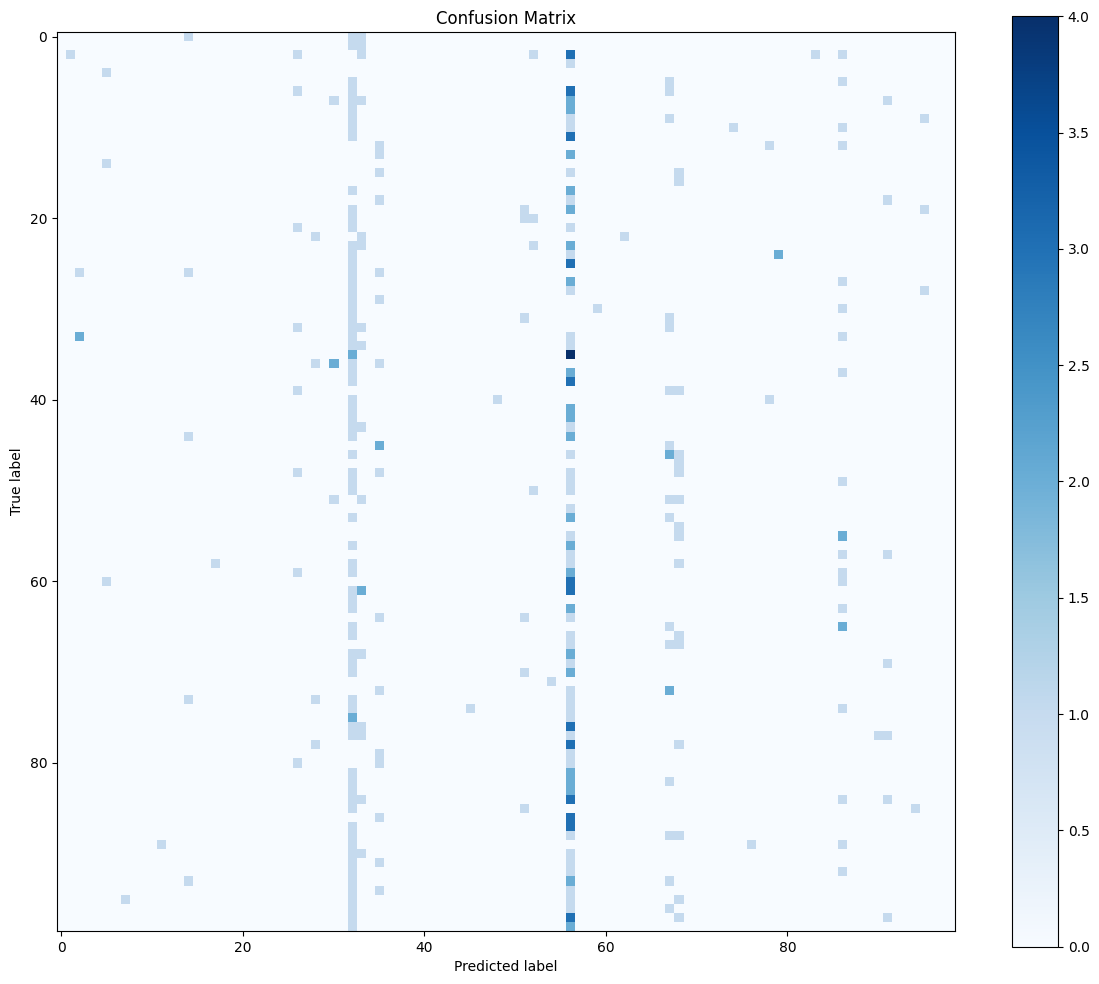

In [ ]:
plot_confusion_matrix(y_true, y_pred)

# Trainer Components
* model
* tokenizer
* training arguments
* train dataset
* eval dataset
* Data Collater
* Compute Metrics
* class_weights: In our case since we are using a custom trainer so we can use a weighted loss we will subclass trainer and define the custom loss.

#### Create QWEN tokenized dataset which will house our train/val parts during the training process but after applying tokenization

In [ ]:
from datasets import DatasetDict

MAX_LEN = 512  # max tokens per sequence

def tokenize_for_classification(dataset: DatasetDict, tokenizer, text_column="text", label_column="labels", max_length=MAX_LEN):
    """
    Tokenizes a DatasetDict for sequence classification.

    Args:
        dataset (DatasetDict): Hugging Face DatasetDict with splits.
        tokenizer: Hugging Face tokenizer corresponding to the model.
        text_column (str): Name of the text column to tokenize.
        label_column (str): Name of the label column.
        max_length (int): Max token length for truncation/padding.

    Returns:
        DatasetDict: Tokenized dataset with torch tensors.
    """

    def preprocessing_function(examples):
        # Tokenize with truncation and padding
        return tokenizer(
            examples[text_column],
            truncation=True,
            max_length=max_length,
            padding="max_length"  # ensures uniform tensor shapes
        )

    # Map preprocessing to all splits
    tokenized_dataset = dataset.map(
        preprocessing_function,
        batched=True,
        remove_columns=[text_column]  # remove raw text to save memory
    )

    # Ensure the label column is correctly formatted for Trainer
    if label_column in tokenized_dataset["train"].column_names and "labels" not in tokenized_dataset["train"].column_names:
      tokenized_dataset = tokenized_dataset.rename_column(label_column, "labels")


    # Set torch format for PyTorch usage
    tokenized_dataset.set_format("torch")

    return tokenized_dataset


In [ ]:
tokenized_datasets = tokenize_for_classification(hf_dataset, tokenizer, text_column="text", label_column="labels", max_length=512)

print(tokenized_datasets)


Map:   0%|          | 0/2720 [00:00<?, ? examples/s]

Map:   0%|          | 0/342 [00:00<?, ? examples/s]

Map:   0%|          | 0/353 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 2720
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 342
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 353
    })
})


## Data Collator
A **data collator** prepares batches of data for training or inference in machine learning, ensuring uniform formatting and adherence to model input requirements. This is especially crucial for variable-sized inputs like text sequences.

### Functions of Data Collator

1. **Padding:** Uniformly pads sequences to the length of the longest sequence using a special token, allowing simultaneous batch processing.
2. **Batching:** Groups individual data points into batches for efficient processing.
3. **Handling Special Tokens:** Adds necessary special tokens to sequences.
4. **Converting to Tensor:** Transforms data into tensors, the required format for machine learning frameworks.

### `DataCollatorWithPadding`

The `DataCollatorWithPadding` specifically manages padding, using a tokenizer to ensure that all sequences are padded to the same length for consistent model input.

- **Syntax:** `collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)`
- **Purpose:** Automatically pads text data to the longest sequence in a batch.
- **Tokenizer:** Uses the provided `tokenizer` for sequence processing, respecting model-specific vocabulary and formatting rules.

This collator is commonly used with libraries like Hugging Face's Transformers, facilitating data preprocessing for various NLP models.


In [ ]:
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer )


### Define custom trainer with classweights
* We will have a custom loss function that deals with the class weights and have class weights as additional argument in constructor

In [ ]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").long()
        outputs = model(**inputs)
        logits = outputs.logits  # standard attribute

        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss

# define training args

In [ ]:

output_dir = "./Qwen2.5-1.5B/genre_classification_run2"

training_args = TrainingArguments(
    output_dir=output_dir,

    # Training batch size
    per_device_train_batch_size=1,      # Small due to 2.5B model
    gradient_accumulation_steps=16,    # Effective batch size = 16

    # Epochs & learning rate
    num_train_epochs=3,                 # Enough for small dataset
    learning_rate=1e-4,                 # Moderate LR
    warmup_steps=50,                    # Small warmup

    # Logging & evaluation
    logging_steps=10,                   # Frequent logging
    eval_steps=50,                      # Evaluate every 50 steps
    evaluation_strategy="steps",

    # Checkpointing
    save_strategy="steps",
    save_steps=200,
    save_total_limit=2,                 # Keep last 2 checkpoints

    # Mixed precision
    fp16=True,                          # Reduce memory usage and speed up

    # Reproducibility
    seed=42,

    # Reporting to WandB
    report_to="wandb",
    run_name="qwen2.5B_genre_classification",  # W&B run name

    # Evaluation batch size (can be larger than training)
    per_device_eval_batch_size=8,

    # Optional: gradient clipping for stability
    gradient_checkpointing=False,       # Can be True to save memory, but slows down training

)


/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


#### Define custom trainer

In [ ]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=collate_fn,
    class_weights=class_weights_tensor,
)

/tmp/ipython-input-3649931911.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)


### Run trainer!

In [ ]:
import time

start_time = time.time()
train_result = trainer.train()
end_time = time.time()

total_time_sec = end_time - start_time
total_time_min = total_time_sec / 60

wandb: Detected [huggingface_hub.inference] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


Step,Training Loss,Validation Loss
50,8.413200,7.601824
100,5.212300,4.946334
150,4.557800,4.692057
200,4.312000,4.498403
250,4.187300,4.364852
300,3.926000,4.226666


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
print(f"Training finished in {total_time_min:.2f} minutes ({total_time_sec:.2f} seconds)")
print(train_result)

Training finished in 27.74 minutes (1664.62 seconds)
TrainOutput(global_step=340, training_loss=5.290865595200483, metrics={'train_runtime': 1663.9543, 'train_samples_per_second': 3.269, 'train_steps_per_second': 0.204, 'total_flos': 2.204873923756032e+16, 'train_loss': 5.290865595200483, 'epoch': 2.0})


In [ ]:
output_dir = "/content/drive/MyDrive/Colab Notebook/Fine_tunning_results/Qwen2.5-1.5B_Fine_tuned__SeqClass_nochunk"

trainer.model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


('/content/drive/MyDrive/Colab Notebook/Fine_tunning_results/Qwen2.5-1.5B_Fine_tuned_run/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebook/Fine_tunning_results/Qwen2.5-1.5B_Fine_tuned_run/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebook/Fine_tunning_results/Qwen2.5-1.5B_Fine_tuned_run/vocab.json',
 '/content/drive/MyDrive/Colab Notebook/Fine_tunning_results/Qwen2.5-1.5B_Fine_tuned_run/merges.txt',
 '/content/drive/MyDrive/Colab Notebook/Fine_tunning_results/Qwen2.5-1.5B_Fine_tuned_run/added_tokens.json',
 '/content/drive/MyDrive/Colab Notebook/Fine_tunning_results/Qwen2.5-1.5B_Fine_tuned_run/tokenizer.json')

#### Let's check the results


In [ ]:
from peft import PeftModel
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load base model in half precision
base_model_id = "Qwen/Qwen2.5-1.5B-Instruct"
model = AutoModelForSequenceClassification.from_pretrained(
    base_model_id,
    num_labels=99,
    torch_dtype=torch.float16,
    device_map={"": "cpu"}  # safe for Colab GPU
)

# Apply LoRA
finetuned_adapter_path = "/content/drive/MyDrive/Colab Notebook/Fine_tunning_results/Qwen2.5-1.5B_Fine_tuned__SeqClass"
model = PeftModel.from_pretrained(model, finetuned_adapter_path)

# Move to GPU
model.to(device)
model.eval()
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = True

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(finetuned_adapter_path)  # safer if special tokens added


Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at Qwen/Qwen2.5-1.5B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
y_true, y_pred, results = evaluate_model(model, tokenizer, hf_dataset, split="test")

Evaluating test: 100%|██████████| 12/12 [00:27<00:00,  2.31s/it]


=== TEST RESULTS ===
Accuracy : 0.0737
Precision: 0.0595
Recall   : 0.0737
F1 score : 0.0573



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import torch
import numpy as np

def predict_genre(model, tokenizer, story, id2genre, max_length=512, device=None):
    """
    Predict the genre of a single story.

    Args:
        model: PEFT/LoRA fine-tuned Qwen2.5B classification model
        tokenizer: corresponding tokenizer
        story: string of the story
        id2genre: dict mapping label IDs to genre names
        max_length: maximum token length per input
        device: "cuda" or "cpu"; defaults to auto-detect

    Returns:
        predicted_genre: string of predicted genre
        confidence: probability of the predicted genre
        all_probs: array of probabilities for all classes
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    model.to(device)
    model.eval()

    # Tokenize the story
    inputs = tokenizer(
        story,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_attention_mask=True
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits  # shape: [1, num_labels]

        # Convert logits to probabilities
        probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]

    # Get predicted class
    pred_id = int(np.argmax(probs))
    predicted_genre = id2genre[pred_id]
    confidence = probs[pred_id]

    return predicted_genre, confidence, probs


In [ ]:
# Your story text
story_text = """
Chapter 1: The Unraveling Threads

In the heart of the bustling city of New York, a young lawyer named John Masters sat in his small, cluttered office. John was a man in his early 30s, with dark brown hair and piercing green eyes. He had just returned from his first case as a defense attorney. The case was a high-profile murder trial, and he was determined to prove the innocence of his client, a young woman named Emily Thompson, who was accused of brutally killing her husband.

Despite the mounting pressure and the overwhelming amount of evidence against Emily, John was convinced that she was innocent. As he sat in his office, he meticulously went through the case files, determined to find the truth. His assistant, a young woman named Lisa, was diligently working on her own, researching any possible lead that might help them in their quest for justice.
"""

# Predict the genre
predicted_genre, confidence, probs = predict_genre(model, tokenizer, story_text, id2genre)

print(f"Predicted Genre: {predicted_genre} (Confidence: {confidence:.2f})")


Predicted Genre: Supernatural Comedy (Confidence: 0.18)
